# Toy Machine Learning Pipeline: Exploratory Data Analysis

*Last update: 04/01/2022*

The present notebook introduces the current model operationalized in the machine learning pipeline. In addition, it illustrates some of the functions to load the data, then has a rapid exploratory data analysis, a review about the features generation, and how the model was fit.

The machine learning task in the project, as described in the [README](https://github.com/shreyashankar/toy-ml-pipeline#ML-task-description-and-evaluation-procedure), is: 

 > *We train* ***a model to predict whether a passenger in a NYC taxicab ride will give the driver a large tip***. *This is a binary classification task. A large tip is arbitrarily defined as greater than 20% of the total fare (before tip).* ***To evaluate the model or measure the efficacy of the model, we measure the F1 score.***


In [183]:
# import some functions from the module io written within utils
from utils.io import list_files, load_output_df, read_file
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

## 1. Load the data

This section shows how to use two functions written in the module `utils.io` to access and load the data stored in s3 buckets.

- `utils.io.list_files()` to explore each component's buckets.
- `utils.io.load_data_df()` to read and load parquet files into pandas' dataframes.

Firstly, we can navigate and explore the data stored in S3.

In [132]:
list_files('test')

['toy-applied-ml-pipeline/test/test.pq']

In [133]:
list_files('dev/clean/2020_01')

['toy-applied-ml-pipeline/dev/clean/2020_01/20210307-172352.pq',
 'toy-applied-ml-pipeline/dev/clean/2020_01/20210414-174617.pq',
 'toy-applied-ml-pipeline/dev/clean/2020_01/20210419-130349.pq',
 'toy-applied-ml-pipeline/dev/clean/2020_01/20210421-155643.pq',
 'toy-applied-ml-pipeline/dev/clean/2020_01/20210429-192900.pq']

We will explore the data using the version `2020_01`.

Now we can use the function `utils.io.load_data_df()`:

In [134]:
clean01 = load_output_df('clean', version='2020_01')

In [135]:
clean01.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2.0,2020-01-01 00:30:07,2020-01-02 00:28:18,1.0,0.35,1.0,N,166,166,1.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0
1,2.0,2020-01-01 00:53:40,2020-01-02 00:18:40,6.0,3.96,1.0,N,246,261,1.0,17.5,0.5,0.5,4.26,0.0,0.3,27.51,2.5
2,2.0,2020-01-01 00:38:39,2020-01-02 00:37:22,2.0,1.03,1.0,N,114,79,1.0,6.5,0.5,0.5,2.58,0.0,0.3,12.88,2.5
3,2.0,2020-01-01 00:13:41,2020-01-02 00:11:35,1.0,4.35,1.0,N,263,113,2.0,15.0,0.5,0.5,0.00,0.0,0.3,18.80,2.5
4,2.0,2020-01-01 00:28:27,2020-01-02 00:26:48,3.0,1.67,1.0,N,161,142,2.0,13.5,0.5,0.5,0.00,0.0,0.3,17.30,2.5


In [136]:
clean01.shape

(5977829, 18)

In [137]:
clean01.dtypes

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

**Note:** You can find the codebook with the description of each column [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

Explore if there are any missing values across the columns.

In [138]:
clean01.isna().any()

VendorID                  True
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count           True
trip_distance            False
RatecodeID                True
store_and_fwd_flag        True
PULocationID             False
DOLocationID             False
payment_type              True
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
congestion_surcharge     False
dtype: bool

Some broad considerations, there are missing values in the columns `VendorID`, `passenger_count`, `RatecodeID`, `store_and_fwd_flag`, and `payment_type`. As well, as indicated in the *pipeline components table* on the README, the data cleaning process performed by the script `etl/cleaning.py` only consists of "drops rows outside the time range or with $0-valued fares)"

## 2. Exploratory Data Analysis

We will perform a quick exploratory data analysis using a smaller subset with 15% of observations from the dataset. Then we will continue with the feature generation to train the model.

In [41]:
subset = clean01.sample(frac=.15)

In [45]:
subset.shape

(896674, 18)

<AxesSubplot:>

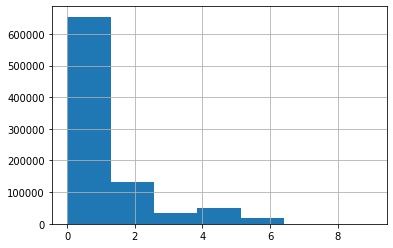

In [46]:
subset.passenger_count.hist(bins=7)

**The vast majority of the trips involved one passenger.** The distribution has a right tail, and there is a minor peak in trips with four passengers that may be related to family groups.

The `trip_distance` column has the elapsed trip distance reported by the taximeter.

In [54]:
subset.trip_distance.mean().round(2)

3.12

A rough mean computed from the subset's `trip_distance` reports that **the average taxi trip is about 3.12 miles**.
Aditionally, we can inspect the trip duration from the datetime columns `tpep_pickup_datetime` and `tpep_dropoff_datetime`.

In [80]:
subset['trip_duration_seconds'] = (subset.tpep_dropoff_datetime - subset.tpep_pickup_datetime).dt.seconds

In [87]:
subset['trip_duration_seconds'].mean() / 60

15.908992305639137

**The average trip duration from this sample is almost 16 minutes.**

How does varies the metrics above when we consider the payment method? Given the information in the codebook we can create a categorical variable with each payment type label.

In [102]:
payment_method = pd.Categorical(subset.payment_type)
payment_method = payment_method.rename_categories({1.0:'Credit Card', 2.0:'Cash', 3.0:'No Charge',
                                                   4.0: 'Dispute', 5.0:'Unknown', 6.0:'Voided Trip'})

In [106]:
subset['payment_method'] = payment_method

In [114]:
subset.groupby(['payment_method']).mean()['trip_distance']

payment_method
Credit Card    2.872679
Cash           2.732138
No Charge      2.857452
Dispute        2.988231
Name: trip_distance, dtype: float64

Why is the trip distance average lower for each payment method than the aggregate average?

Let's explore the missing values of trip distance that are out of the average. We can take the mean from the rows that have missing values in the payment method column.

In [121]:
subset.loc[subset['payment_method'].isna(),'trip_distance'].mean()

30.161012385568128

The average is considerably higher than the averages by payment methods; and is evidence of outliers or some errors in the data.

In [128]:
subset.loc[subset['payment_method'].isna(),'trip_distance'].max()

210240.07

In [123]:
subset.loc[subset['trip_distance'] > 2e5]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration_seconds,payment_method
5973185,NaN,2020-01-28 07:37:00,2020-01-28 08:42:00,NaN,210240.07,NaN,None,76,231,NaN,37.77,2.75,0.5,0.0,0.0,0.3,41.32,0.0,3900,NaN


A trip of more than 200k miles in 1 hour? 
We take notes of this for cleaning the data.

In [130]:
subset.groupby(['payment_method']).mean()['trip_duration_seconds']/60

payment_method
Credit Card    15.711091
Cash           16.093246
No Charge      10.572905
Dispute        11.219615
Name: trip_duration_seconds, dtype: float64

**The duration by payment method is closer to the aggregate mean for credit and cash.** It makes sense to think that most of the trips fall in these two categories. On the other hand, no charge and dispute trips have a duration of around 11 minutes approximately.

## 3. Feature generation

In this section, we explore and reproduce the featured generated by the `etl/featuregen.py` file.

The file `utils/feature_generators.py` contain classes that encode the computations to generate the features for each trip used by the original model.

### 3.1 Compute time context features

Let's start computing featurses related to the pickup times and storing all the feature columns that we will used to train the model in a dataframe.

In [140]:
subset.head(n=1)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration_seconds,payment_method
1966183,2.0,2020-01-12 04:09:15,2020-01-12 04:15:02,2.0,1.6,1.0,N,246,48,1.0,7.0,0.5,0.5,2.16,0.0,0.3,12.96,2.5,347,Credit Card


We can extract different components from a datetime column:

In [141]:
pickup_weekday = subset.tpep_pickup_datetime.dt.weekday
pickup_hour = subset.tpep_pickup_datetime.dt.hour
pickup_minute = subset.tpep_pickup_datetime.dt.minute

Compute the boolean column `work_hours` that indicates `True` when there is a record within work hours from Monday to Friday. Otherwise, it gives you a `False`.

Notice that the weekday's method return an integer from 0 to 6, starting from Monday.

In [142]:
work_hours = (pickup_weekday >= 0) & (pickup_weekday <= 4) & (pickup_hour >= 8) & (pickup_hour <= 18)

In [143]:
feature_df = pd.DataFrame({'pickup_weekday' : pickup_weekday,
                           'pickup_hour' : pickup_hour,
                           'pickup_minute' : pickup_minute,
                           'work_hours' : work_hours})

In [144]:
feature_df.head(n=5)

,pickup_weekday,pickup_hour,pickup_minute,work_hours
1966183,6,4,9,False
3393899,5,21,11,False
4554098,4,17,36,True
1739027,5,2,7,False
5436053,1,22,25,False


### 3.2 Compute trip metrics

We will compute trip metrics such as `trip_time` and `trip_speed` and use other information in the data like passengers and trip distance to train the model.

In [145]:
trip_time = (subset.tpep_dropoff_datetime - subset.tpep_pickup_datetime).dt.seconds
trip_speed = subset.trip_distance / (trip_time + 1e7)

Notice that the trip distance is divided by the trip time plus an error disturbance (i.e. `trip_time + 1e7`) for avoid dividing by 0

In [147]:
feature_df['trip_distance'] = subset.trip_distance
feature_df['trip_time'] = trip_time
feature_df['trip_speed'] = trip_speed
feature_df['passenger_count'] = subset.passenger_count

In [148]:
feature_df.head()

,pickup_weekday,pickup_hour,pickup_minute,work_hours,trip_distance,trip_time,trip_speed,passenger_count
1966183,6,4,9,False,1.60,347,1.599944e-07,2.0
3393899,5,21,11,False,3.41,765,3.409739e-07,5.0
4554098,4,17,36,True,1.60,460,1.599926e-07,1.0
1739027,5,2,7,False,4.09,726,4.089703e-07,1.0
5436053,1,22,25,False,3.30,997,3.299671e-07,1.0


### 3.3 Location features

Finally, the dataset provides location features in which different ids give information to identify different zones, which could be helpful for the prediction task.

In [151]:
feature_df['PULocationID'] = pd.Categorical(subset['PULocationID'])
feature_df['DOLocationID'] = pd.Categorical(subset['DOLocationID'])
feature_df['RatecodeID'] = pd.Categorical(subset['RatecodeID'])

Therefore, the feature matrix it has the following columns:

In [152]:
feature_df.head()

,pickup_weekday,pickup_hour,pickup_minute,work_hours,trip_distance,trip_time,trip_speed,passenger_count,PULocationID,DOLocationID,RatecodeID
1966183,6,4,9,False,1.60,347,1.599944e-07,2.0,246,48,1.0
3393899,5,21,11,False,3.41,765,3.409739e-07,5.0,33,256,1.0
4554098,4,17,36,True,1.60,460,1.599926e-07,1.0,229,236,1.0
1739027,5,2,7,False,4.09,726,4.089703e-07,1.0,79,263,1.0
5436053,1,22,25,False,3.30,997,3.299671e-07,1.0,13,234,1.0


## 4. Train the model

**The goal is to build a binary classification model to predict high tips from the lower ones.** A high tip is defined for every trip, in which the tip amount is 20% greater than the total fare amount.

As in the README said, the cutoff is arbitrary and its encode in the response variable as follows:

In [159]:
high_tip_indicator = subset.tip_amount / subset.fare_amount > .2

In [160]:
high_tip_indicator

1966183     True
3393899    False
4554098     True
1739027     True
5436053     True
           ...  
5075594     True
1108107     True
2594424     True
983202      True
1339254    False
Length: 896674, dtype: bool

In [162]:
feature_df.shape, high_tip_indicator.shape

((896674, 11), (896674,))

The model used in production was trained using the data from the periods `2020_10` and `2020_11`. The test data was from `2020_12`. 

**We will use only a sample from 2020_01 data to train and test the model.** This reason aims to illustrate the training process, and the model obtained achieves a similar accuracy metric as the reported in the README.

### 4.1 Split the data

Use `train_test_split` to create the training and testing datasets using 80% and 20% of the data, respectively.


In [163]:
X_train, X_test, y_train, y_test = train_test_split(feature_df, 
                                                    high_tip_indicator, 
                                                    test_size = .2, 
                                                    random_state = 42)

### 4.2 Fit the current model

The model is random forest classifiers which parameters are specified in `utils/models.py`.

In [164]:
RANDOM_STATE = 42
ALL_PROCESSORS = -1
IMPUTATION_VALUE = -1.0
model_params = { 'max_depth': 10, 'n_jobs': ALL_PROCESSORS, 'random_state': RANDOM_STATE}

Check for any missing values on the dataset before training the model.

In [165]:
# we can count how many missing values has every column
for col_name in X_test.columns:
    print(col_name, ' : ', str(X_test[col_name].isna().sum()))

pickup_weekday  :  0
pickup_hour  :  0
pickup_minute  :  0
work_hours  :  0
trip_distance  :  0
trip_time  :  0
trip_speed  :  0
passenger_count  :  1847
PULocationID  :  0
DOLocationID  :  0
RatecodeID  :  1847


Use the `IMPUTATION_VALUE` to fill the missing values on `passenger_count` and `RatecodeID`.

In [166]:
X_train.RatecodeID = X_train.RatecodeID.cat.add_categories(IMPUTATION_VALUE)
X_train.RatecodeID = X_train.RatecodeID.fillna(IMPUTATION_VALUE)

In [167]:
X_test.passenger_count = X_test.passenger_count.fillna(IMPUTATION_VALUE)

In [168]:
X_test.RatecodeID = X_test.RatecodeID.cat.add_categories(IMPUTATION_VALUE)
X_test.RatecodeID = X_test.RatecodeID.fillna(IMPUTATION_VALUE)

In [169]:
X_train.passenger_count = X_train.passenger_count.fillna(IMPUTATION_VALUE)

The imputation avoids that the training algorithm throw an error.

In [170]:
model = RandomForestClassifier(**model_params)

In [171]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Now we can train the model:

In [172]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

### 4.3 Validate the model

We will use the F1-score to measure the accuracy of the model.

Let's check the performance in-the-sample dataset.

In [177]:
y_pred = model.predict(X_train).round()
f1_score(y_train, y_pred)

0.732751447638778

Now, let's check the f1-score generalization out-of-sample.

In [181]:
y_pred = model.predict(X_test).round()
f1_score(y_test, y_pred)

0.7295319097508101

**The score is pretty similar at the 71.6% reported in the [README](https://github.com/shreyashankar/toy-ml-pipeline).**

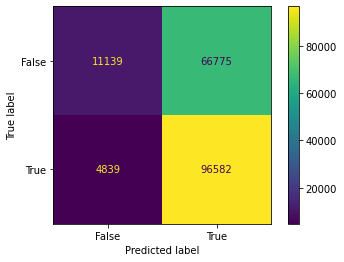

In [185]:
%%capture --no-display
plot_confusion_matrix(model, X_test, y_test)  